In [42]:
# importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [21]:
# importando dataframe
df = pd.read_csv(r'C:\Users\wggso\OneDrive\Documentos\Data_Science\cluster\Mall_Customers.csv')
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [22]:
# drop coluna ID
df = df.drop(columns= 'CustomerID')

print('Valores nulos: ', df.isnull().sum()) # contando nulos

print('Tipos:', df.dtypes)  # tipo das variáveis

print(df.describe().T) # estatísticas das variáveis numéricas

Valores nulos:  Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Tipos: Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
                        count   mean        std   min    25%   50%   75%  \
Age                     200.0  38.85  13.969007  18.0  28.75  36.0  49.0   
Annual Income (k$)      200.0  60.56  26.264721  15.0  41.50  61.5  78.0   
Spending Score (1-100)  200.0  50.20  25.823522   1.0  34.75  50.0  73.0   

                          max  
Age                      70.0  
Annual Income (k$)      137.0  
Spending Score (1-100)   99.0  


#### insights
- A faixa etária da maioria do meu público esta concentrado em até 49 anos;
- renda anual esta concentrado em até 78k, temos valores muito baixo e muito altos (vou avaliar se tem correlação com age);
- pontuacao de gastos temos valores muito baixos (possíveis outliers?)

##### Correlação

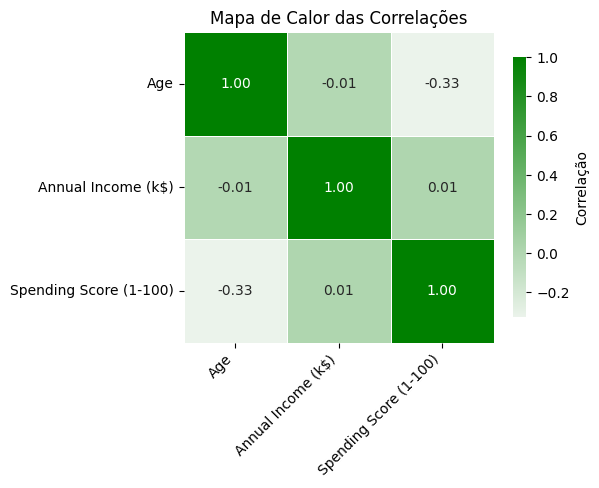

In [23]:
# Calcula a correlação
corr = df.corr(numeric_only=True)

# Cria um mapa de calor com gradiente verde claro → verde escuro
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=sns.light_palette("green", as_cmap=True),  # Armonizar cores
    annot_kws={"size": 10},
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlação"}
)

plt.xticks(rotation=45, ha='right')
plt.title("Mapa de Calor das Correlações", fontsize=12)
plt.tight_layout()
plt.show()

#### insights

- **Score x Age:** Correlação -0.33 Clientes mais velhos tendem a ter menor pontuação de gastos, enquanto os mais jovens gastam mais.
- Campanhas mais agressivas ou produtos premium podem funcionar melhor com o público mais jovem.

- **Renda Anual x Score:** Correlação 0.01 Praticamente nenhuma relação entre quanto a pessoa ganha e quanto ela gasta na loja.
- Estratégias baseadas apenas em renda não são eficazes para segmentação de clientes.

- **Idade x Renda Anual:** Correlação -0.01 Não há relação clara entre idade e renda nessa base.
- não podemos assumir que pessoas mais velhas ganham mais.

#### Genero ####
- masculino 0
- feminino 1

In [ ]:
df['genero_dummy'] = df['Genre'].map({'Male': 0, 'Female': 1}) # dummy

# media salarial e pontuacao por genero
df.groupby('Genre')['Annual Income (k$)'].mean()
df.groupby('Genre')['Spending Score (1-100)'].mean()

Genre
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64

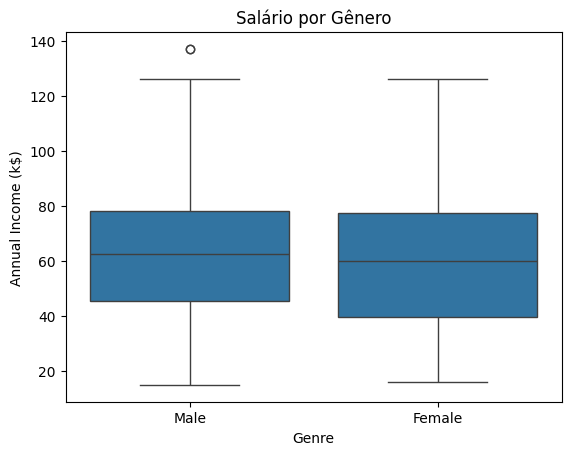

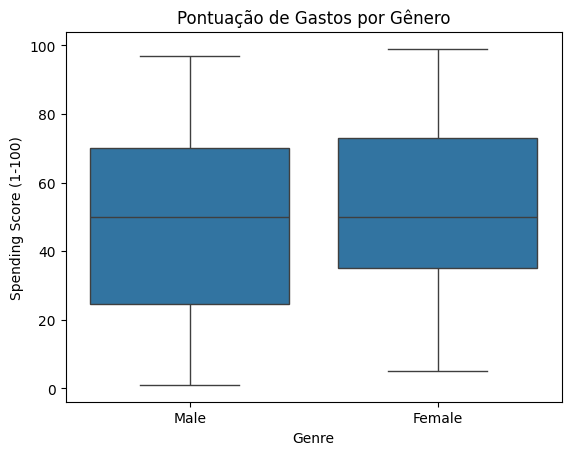

In [34]:
# boxplot por genero
sns.boxplot(x='Genre', y='Annual Income (k$)', data=df)
plt.title('Salário por Gênero')
plt.show()

sns.boxplot(x='Genre', y='Spending Score (1-100)', data=df)
plt.title('Pontuação de Gastos por Gênero')
plt.show()

Teste T

In [38]:
# salario
masc = df[df['Genre'] == 'Male']['Annual Income (k$)']
fem  = df[df['Genre'] == 'Female']['Annual Income (k$)']

t_stat, p_value = ttest_ind(masc, fem, equal_var=False)
print(f"salario p-valor: {p_value}")

salario p-valor: 0.4289430477499149


In [37]:
# Score
masc_score = df[df['Genre'] == 'Male']['Spending Score (1-100)']
fem_score = df[df['Genre'] == 'Female']['Spending Score (1-100)']

t_stat, p_value = ttest_ind(masc_score,fem_score, equal_var=False)
print(f"Score p-valor: {p_value}")

Score p-valor: 0.42199772447783646


##### Conclusao Genero #####
##### vou desconsiderar essa variável para cluster e depois rodo clusters separados por genero:
- analisando os gráficos consegui ver que estatisticamente salario e score estão bem próximos para ambos os sexos;
- Teste T não descarto H0 pois não há evidência estatística suficiente para dizer que são diferentes;
- para cluster não é interessante tecnicamente usar dummy conding a não ser que estatísticamente as variáveis considerando genero fossem diferentes.

#### Cluster ####

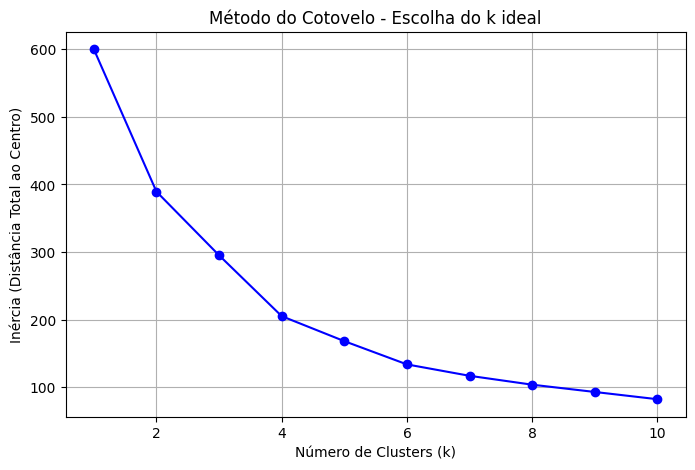

In [ ]:
# selecionando apenas colunas numéricas relevantes
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# define o intervalo de clusters para testar (ex: de 1 a 10)
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# plotando o gráfico do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Distância Total ao Centro)')
plt.title('Método do Cotovelo - Escolha do k ideal')
plt.grid(True)
plt.show()

In [ ]:
# Aplicando KMeans com k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

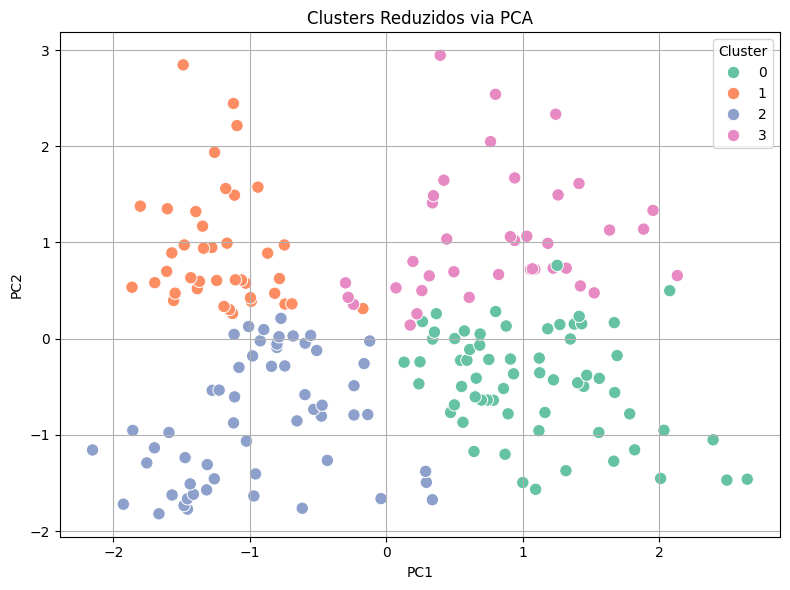

In [ ]:
# reduzinado para 2 dimensões com PCA (preserva a variacao dos dados)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df['PC1'] = pca_components[:, 0]
df['PC2'] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=df,
    palette='Set2',
    s=80
)
plt.title('Clusters Reduzidos via PCA')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\wggso\AppData\Local\Temp\ipykernel_39448\4101900241.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


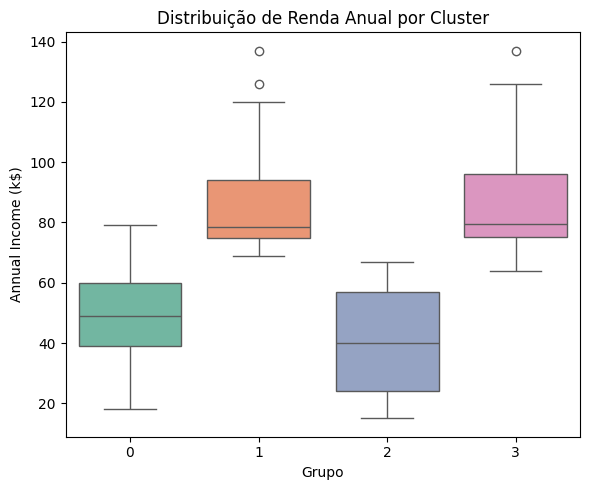

In [ ]:
# Renda anual
plt.figure(figsize=(6, 5))

sns.boxplot(
    x='Cluster',
    y='Annual Income (k$)',
    data=df,
    palette='Set2'
)

plt.title('Distribuição de Renda Anual por Cluster')
plt.xlabel('Grupo')
plt.ylabel('Annual Income (k$)')
plt.tight_layout()
plt.show()

C:\Users\wggso\AppData\Local\Temp\ipykernel_39448\983805852.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


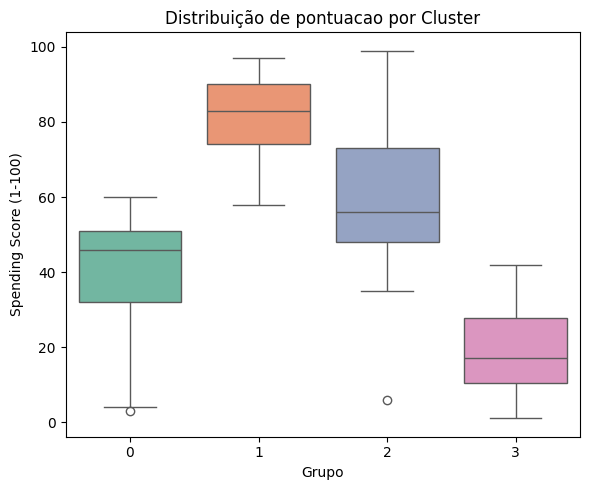

In [49]:
# 
plt.figure(figsize=(6, 5))

sns.boxplot(
    x='Cluster',
    y='Spending Score (1-100)',
    data=df,
    palette='Set2'
)

plt.title('Distribuição de pontuacao por Cluster')
plt.xlabel('Grupo')
plt.ylabel('Spending Score (1-100)')
plt.tight_layout()
plt.show()

C:\Users\wggso\AppData\Local\Temp\ipykernel_39448\4293447.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


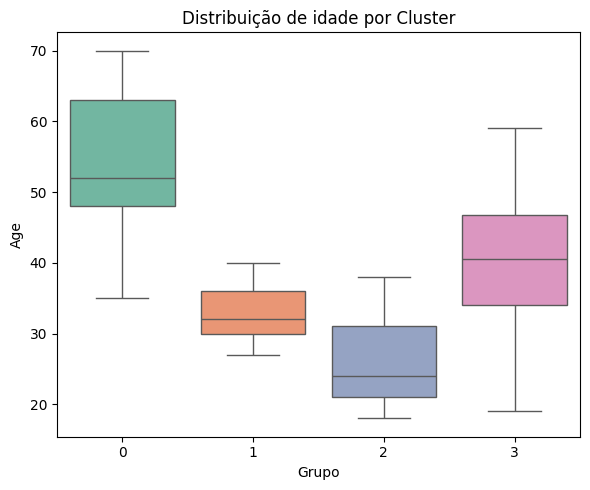

In [50]:
plt.figure(figsize=(6, 5))

sns.boxplot(
    x='Cluster',
    y='Age',
    data=df,
    palette='Set2'
)

plt.title('Distribuição de idade por Cluster')
plt.xlabel('Grupo')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

## Conclusão Final da Análise de Clusters

A análise de cluster K-Means foi realizada utilizando as variáveis `Age`, `Annual Income (k$)` e `Spending Score (1-100)`. Foram identificados quatro clusters com perfis distintos:

### Cluster 0 – Perfil Conservador
- **Idade (mediana):** ~50 anos  
- **Renda anual:** ~50 k$  
- **Spending Score:** 30–60  
- **Descrição:** Clientes maduros, com padrão de consumo equilibrado, priorizam valor e durabilidade.  
- **Recomendações:** Ofertas enfocadas em garantias, benefícios de longo prazo e segurança.

### Cluster 1 – Perfil Premium Ativo
- **Idade (mediana):** 30–40 anos  
- **Renda anual:** ≥ 80 k$  
- **Spending Score:** 70–95  
- **Descrição:** Público jovem com alto poder aquisitivo e elevado engajamento de compra.  
- **Recomendações:** Campanhas premium, programas de fidelidade e oportunidades de upsell.

### Cluster 2 – Perfil Jovem de Baixa Renda
- **Idade (mediana):** 20–30 anos  
- **Renda anual:** ≤ 40 k$  
- **Spending Score:** 45–80  
- **Descrição:** Jovens com menor renda, porém comportamento de compra acima da média.  
- **Recomendações:** Produtos acessíveis, facilidades de pagamento e estímulos visuais.

### Cluster 3 – Perfil de Alta Renda e Baixo Engajamento
- **Idade (mediana):** 35–45 anos  
- **Renda anual:** ≥ 80 k$  
- **Spending Score:** 5–30  
- **Descrição:** Clientes com alto poder aquisitivo, porém baixo nível de compra.  
- **Recomendações:** Campanhas de reativação, ofertas exclusivas e gatilhos de curiosidade.

---

**Considerações finais:**  
- A clusterização comprovou a eficácia na segmentação de público.  
- Estratégias customizadas por cluster tendem a melhorar conversão e retenção.  
- Recomenda-se monitorar periodicamente a estabilidade dos clusters e ajustar segmentações conforme novos dados.
